# Setup

In [1]:
import copy
import numpy as np
import pandas as pd
import anndata as an
import scanpy as sc
import os
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [2]:
# Make sure you run Jupyter Notebook from project root
# DO NOT RUN MULTIPLE TIMES
%cd ..
filename = "GSE72857_accession_formatted.csv"
results_file = 'write/pbmc3k.h5ad'
if not os.path.exists('write'):
    os.makedirs('write')

c:\Users\andissa\Desktop\Project Github\CS-7641-Project


In [3]:
#Code to set global figure settings (feel free to remove, I just added to make the graphs look cleaner)
sc.settings.set_figure_params(dpi=80)

In [4]:
adata = sc.read_csv(filename, first_column_names=True).T
adata

AnnData object with n_obs × n_vars = 10368 × 27297

# Preprocessing

In [5]:
count_depth = np.sum(adata.X, axis = 1)
print("count depth shape:{}".format(count_depth.shape))
#print(count_depth)
number_of_genes = np.sum(adata.X>0,axis=1)
print("number_of_genes shape:{}".format(number_of_genes.shape))
#print(number_of_genes)

count depth shape:(10368,)
number_of_genes shape:(10368,)


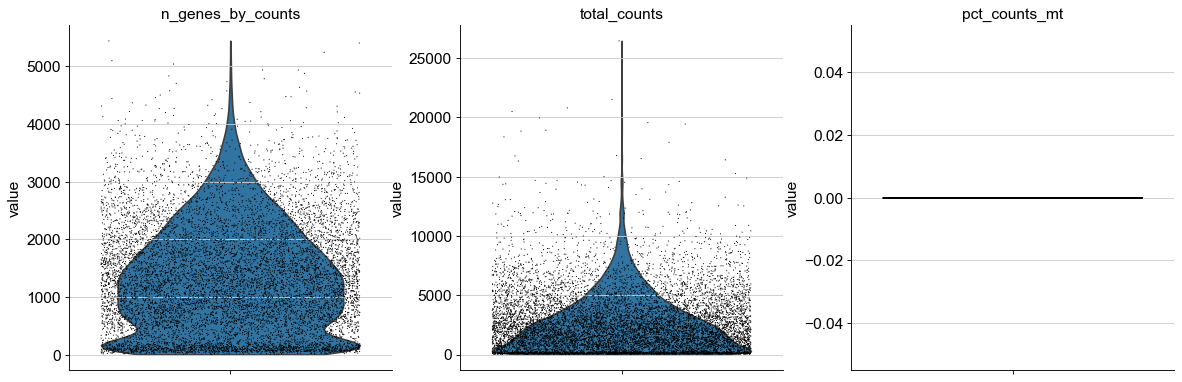

In [6]:
# when/where/why do we do violin plots? 
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

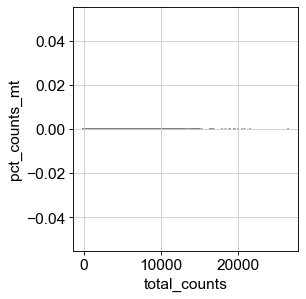

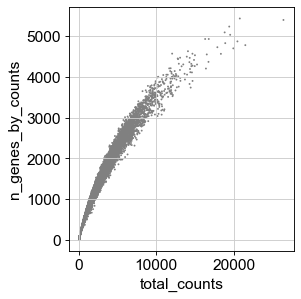

In [7]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Text(0, 0.5, 'unique genes')

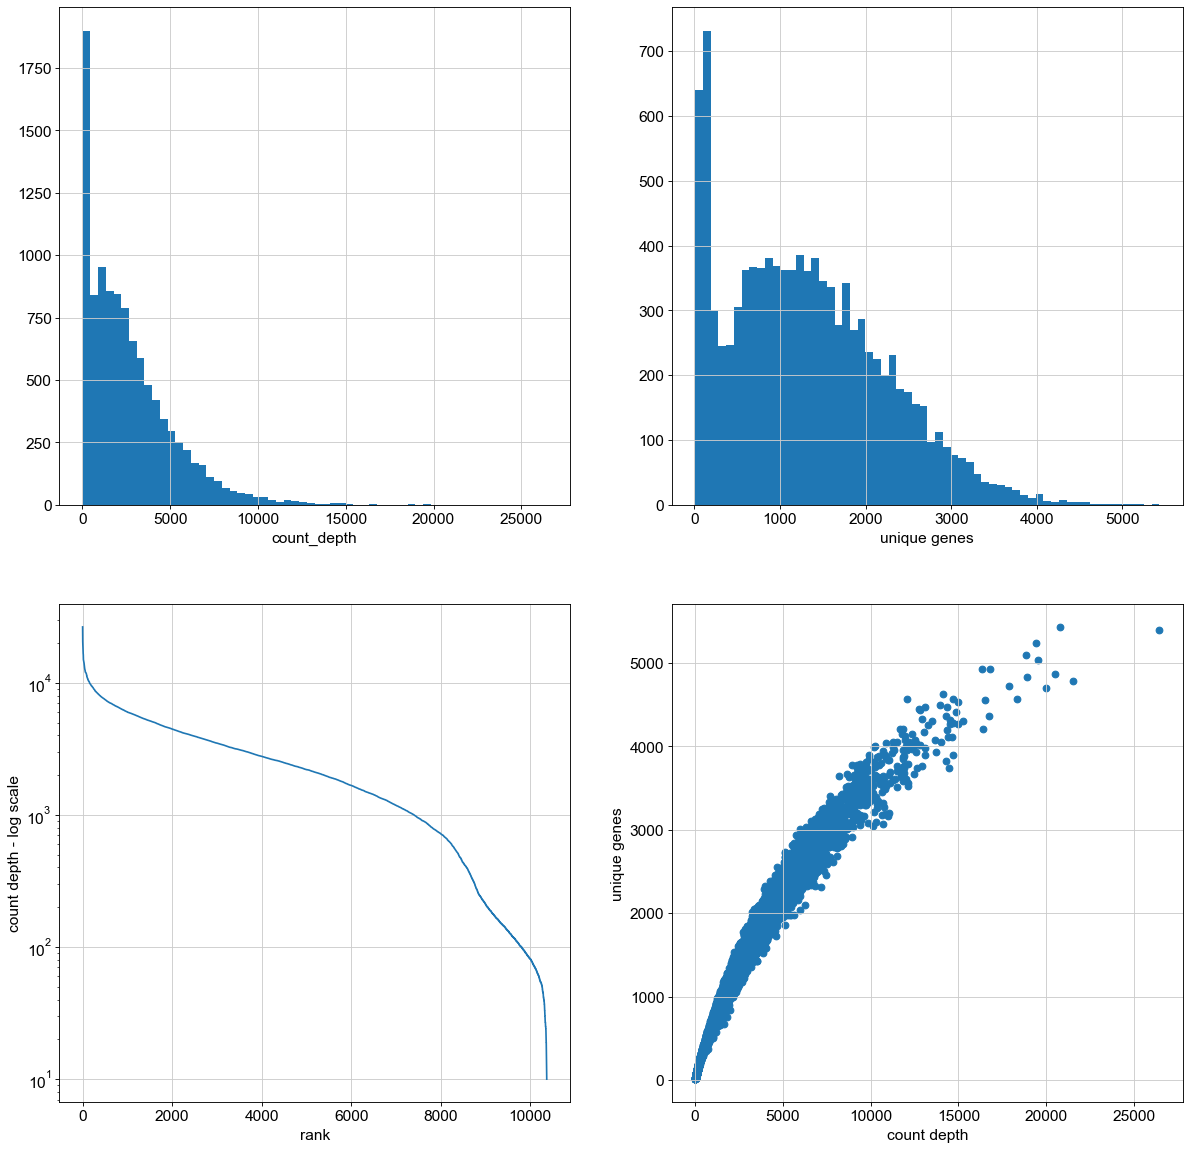

In [8]:
plt.rcParams["figure.figsize"] = [18,18]
fig, axs = plt.subplots(2, 2)
axs[0,0].hist(count_depth,bins=60)
#axs[0,0].set_yscale("log")
axs[0,0].set_xlabel("count_depth")

axs[0,1].hist(number_of_genes,bins=60)
#axs[0,1].set_yscale("log")
axs[0,1].set_xlabel("unique genes")

axs[1,0].plot(range(len(count_depth)),sorted(count_depth,reverse=True))
axs[1,0].set_yscale("log")
axs[1,0].set_xlabel("rank")
axs[1,0].set_ylabel("count depth - log scale")

axs[1,1].scatter(count_depth,number_of_genes)
axs[1,1].set_xlabel("count depth")
axs[1,1].set_ylabel("unique genes")

Text(0.5, 0, 'unique genes')

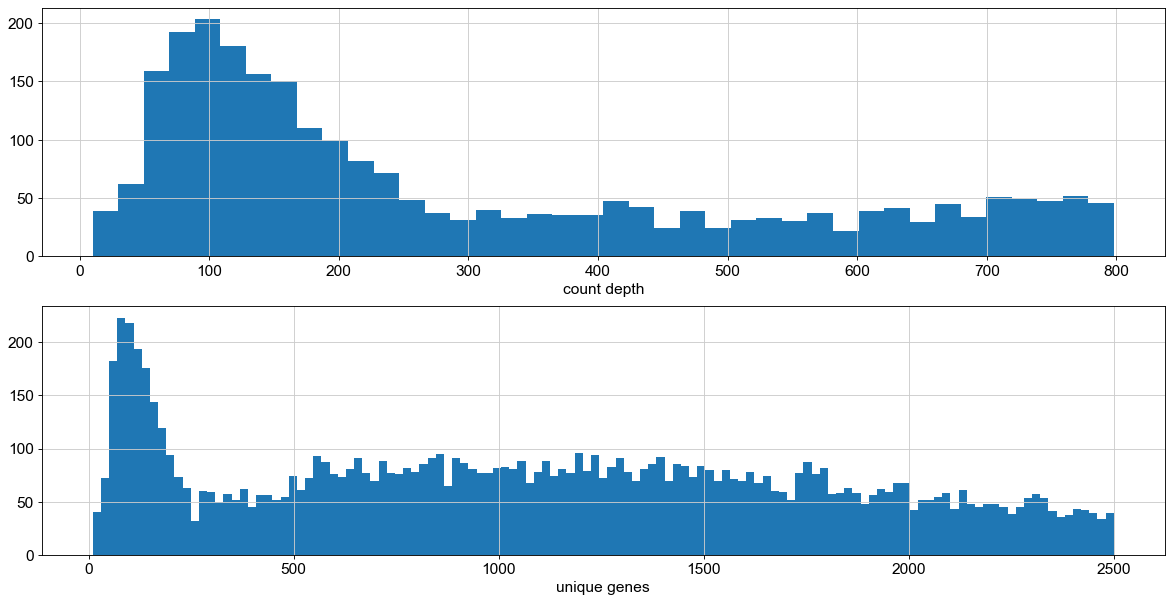

In [9]:
plt.rcParams["figure.figsize"] = [18,9]
fig2, axs2 = plt.subplots(2, 1)

mindepth = 1
maxdepth = 800
mingenes = 1
maxgenes = 2500

#axs2[0].hist(count_depth[np.where((count_depth <= maxdepth) & (count_depth >= mindepth))], bins=min([200,int(maxdepth/20)]),cumulative=True)
axs2[0].hist(count_depth[np.where((count_depth <= maxdepth) & (count_depth >= mindepth))], bins=min([200,int(maxdepth/20)]),cumulative=False)
#axs2[0].set_yscale("log")
axs2[0].set_xlabel("count depth")
#axs2[0].hist(count_depth[np.where((count_depth < maxdepth))], bins=21)

axs2[1].hist(number_of_genes[np.where((number_of_genes<=maxgenes) & (number_of_genes >= mingenes))],bins=min([200,int(maxgenes/20)]),cumulative=False)
#axs2[1].set_yscale("log")
axs2[1].set_xlabel("unique genes")
#axs2[1].hist(number_of_genes[np.where((number_of_genes<maxgenes) )],bins=21)

I'll have to check how this dataset was collected, but it looks like these cells may already have been FACS sorted against some kind of live/dead stain prior to scRNA-seq, they are clean and missing populations with features characteristic of lysed cells


In [10]:
adata_filtered = copy.deepcopy(adata)
print(adata_filtered.X.shape)

sc.pp.filter_genes(adata_filtered, min_counts = 1)
print(adata_filtered.X.shape)

sc.pp.filter_cells(adata_filtered, min_counts = 300)
print(adata_filtered.X.shape)

sc.pp.filter_cells(adata_filtered, min_genes = 500)
print(adata_filtered.X.shape)

(10368, 27297)
(10368, 16162)
(8758, 16162)
(8100, 16162)


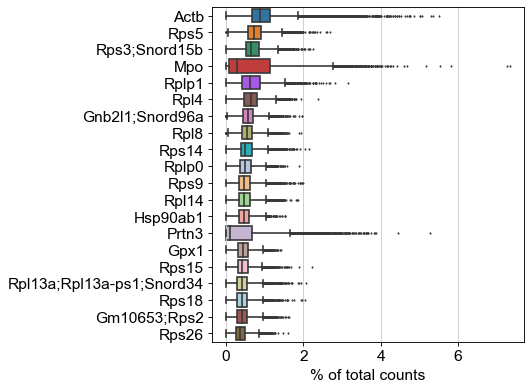

In [11]:
sc.pl.highest_expr_genes(adata_filtered, n_top=20, )

In [12]:
filtered_copy = copy.deepcopy(adata_filtered)

In [13]:
# the lines above do not actually reduce the dataset from 16000 to 2200 genes, they just annotate var with a "highly_variabl" boolean tag, and 10 metrics of variability
adata_filtered
adata_filtered.var[adata_filtered.var['highly_variable']]

KeyError: 'highly_variable'

# PCA

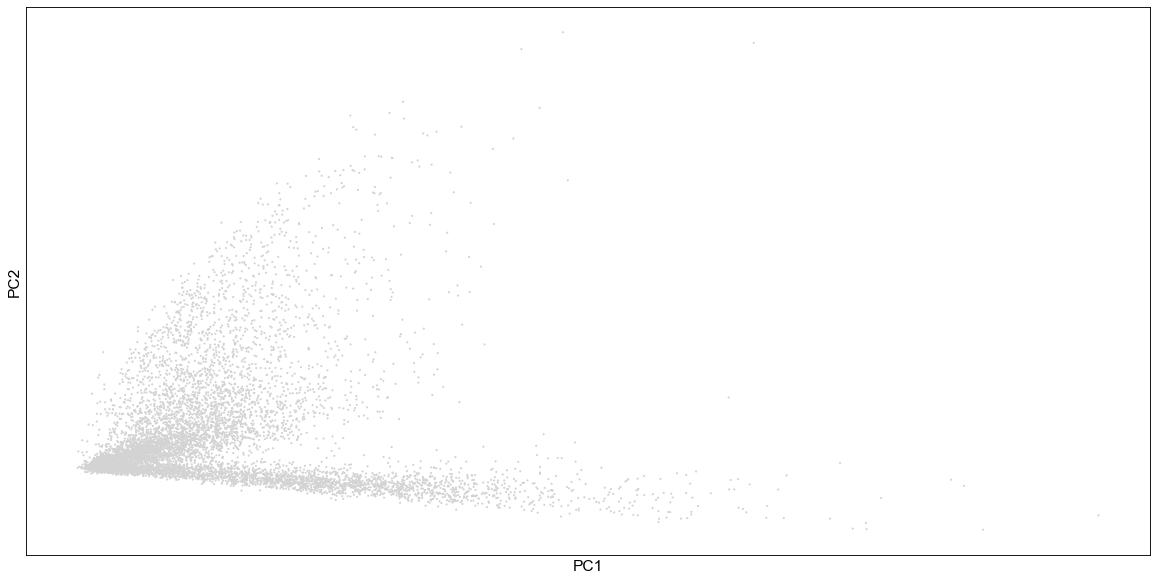

In [14]:
sc.tl.pca(adata_filtered, svd_solver='arpack') # TODO: look at 'arpack' svd solver
sc.pl.pca(adata_filtered) #, color='CST3')

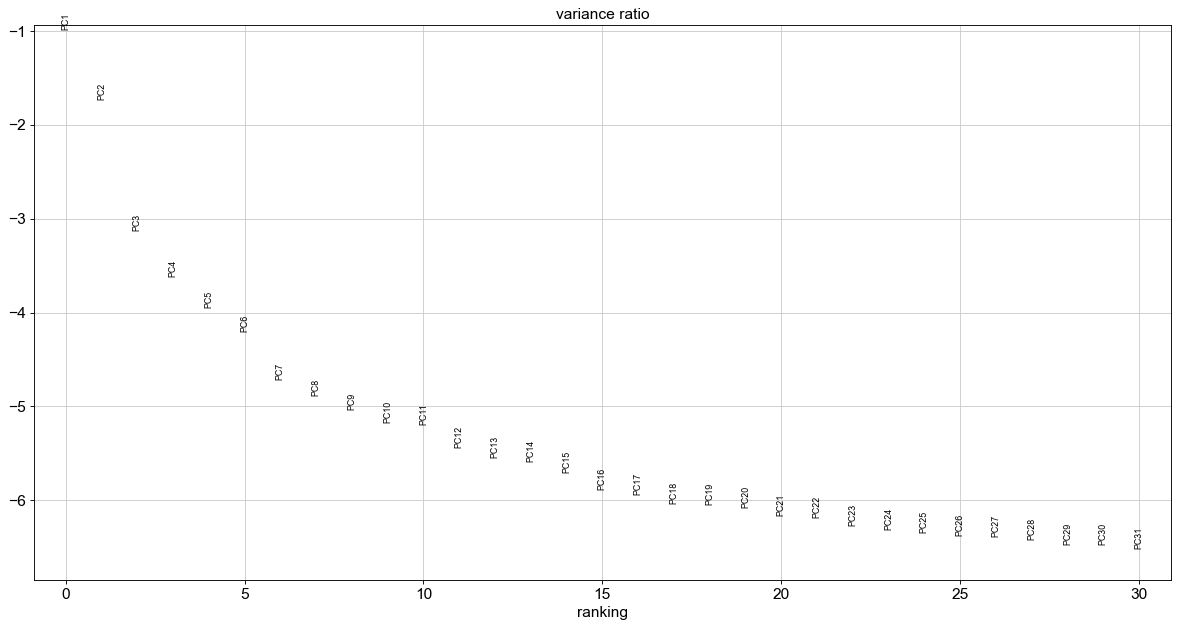

In [15]:
sc.pl.pca_variance_ratio(adata_filtered, log=True) # that's hot

In [16]:
adata_filtered.write(results_file)
adata_filtered

AnnData object with n_obs × n_vars = 8100 × 16162
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## DPT score assignment - before cell cycle regression

In [17]:
adata_filtered.uns['iroot'] = 0 
sc.pp.neighbors(adata_filtered, n_neighbors=15, n_pcs=14, knn=True, random_state=0, method='gauss', metric='euclidean', key_added=None, copy=False)
sc.tl.dpt(adata_filtered, n_dcs=14, n_branchings=0)
adata_filtered.obs["dpt_pseudotime"]

W29954    0.000000
W29956    0.025567
W29957    0.184035
W29958    0.040958
W29960    0.059279
            ...   
W76317    0.115748
W76324    0.076568
W76331    0.071581
W76332    0.157580
W76333    0.256926
Name: dpt_pseudotime, Length: 8100, dtype: float32

Text(0, 0.5, 'dpt_score')

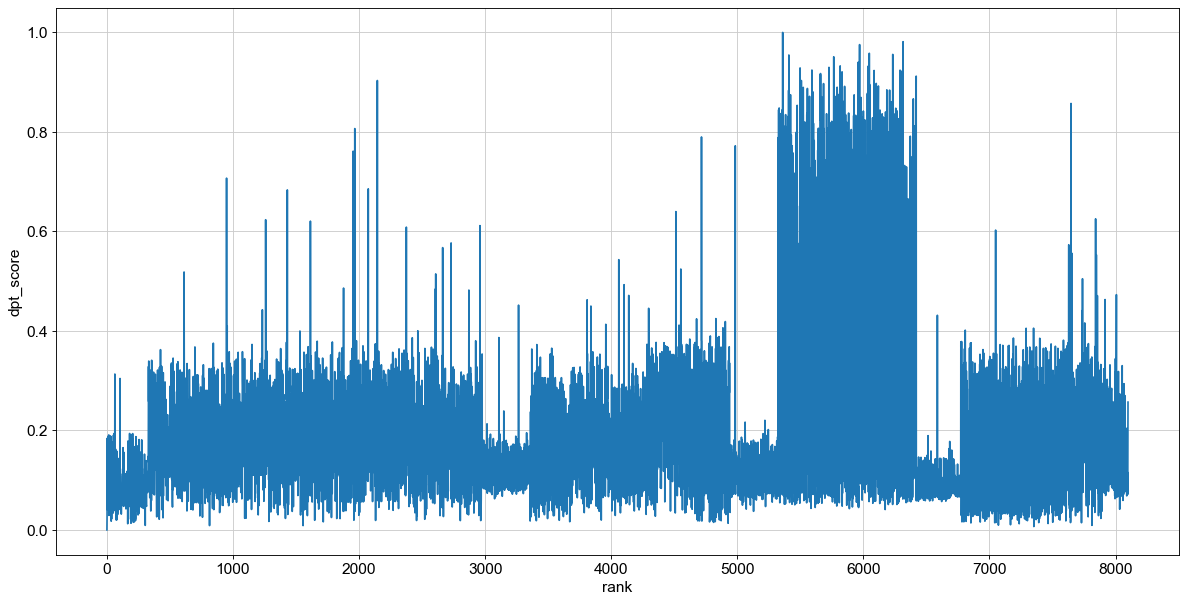

In [18]:
fig3, axs3 = plt.subplots(1, 1)

dpt_scores = list(adata_filtered.obs["dpt_pseudotime"])

axs3.plot(range(len(dpt_scores)),dpt_scores)
#axs[0].set_yscale("log")
axs3.set_xlabel("rank")
axs3.set_ylabel("dpt_score")

# Cell Cycle Regression

In [19]:
cell_cycle_file = 'cell_cycle_genes.txt'

cell_cycle_genes = [x.strip() for x in open(cell_cycle_file)]

s_genes = cell_cycle_genes[:91]
g2m_genes = cell_cycle_genes[91:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_filtered.var_names]

#sc.pp.filter_cells(adata_filtered, min_genes=200)
#sc.pp.filter_genes(adata_filtered, min_cells=3)
sc.pp.normalize_per_cell(adata_filtered)

sc.pp.log1p(adata_filtered)
sc.pp.scale(adata_filtered)

sc.tl.score_genes_cell_cycle(adata_filtered, s_genes, g2m_genes)

... storing 'phase' as categorical


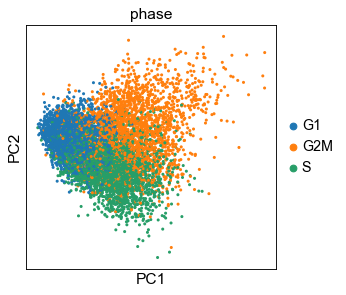

In [20]:
sc.settings.set_figure_params(dpi=80)
adata_cc_genes = adata_filtered[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca(adata_cc_genes, color='phase', size = 30)
#Plot: PCA before regressing out cell-cycle genes

In [21]:
# TODO: look at what regress_out is doing for report
# may be able to implement cell cycle 
sc.pp.regress_out(adata_filtered, ['total_counts', 'pct_counts_mt','S_score', 'G2M_score'])
sc.pp.scale(adata_filtered, max_value=10)

... storing 'phase' as categorical


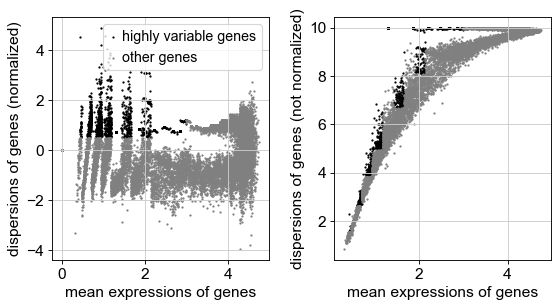

In [22]:
sc.pp.highly_variable_genes(adata_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_filtered)
adata_filtered.raw = adata_filtered

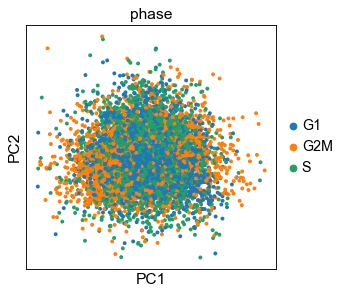

In [23]:
#adata_cc_genes constains the data with regressed out cell-cycle effects
adata_cc_genes = adata_filtered[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca(adata_cc_genes, color='phase', size = 50)
#Plot: PCA after regressing out cell-cycle genes

## DPT after cell cycle regression

In [24]:
adata_cc_genes.uns['iroot'] = 0
sc.pp.neighbors(adata_cc_genes, n_neighbors=15, n_pcs=14, knn=True, random_state=0, method='gauss', metric='euclidean', key_added=None, copy=False)
sc.tl.dpt(adata_cc_genes, n_dcs=14, n_branchings=0)
adata_cc_genes.obs["dpt_pseudotime"]

W29954    0.000000
W29956    0.025567
W29957    0.184035
W29958    0.040958
W29960    0.059279
            ...   
W76317    0.115748
W76324    0.076568
W76331    0.071581
W76332    0.157580
W76333    0.256926
Name: dpt_pseudotime, Length: 8100, dtype: float32

Text(0, 0.5, 'dpt_score_after_CCR')

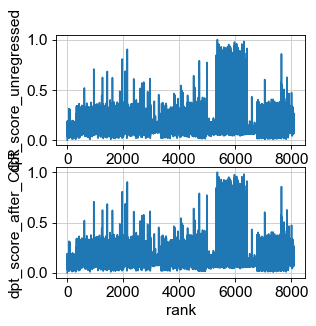

In [25]:
fig4, axs4 = plt.subplots(2, 1)

dpt_scores_after_CCR = list(adata_cc_genes.obs["dpt_pseudotime"])

axs4[0].plot(range(len(dpt_scores)),dpt_scores)
axs4[0].set_xlabel("rank")
axs4[0].set_ylabel("dpt_score_unregressed")

axs4[1].plot(range(len(dpt_scores)),dpt_scores_after_CCR)
axs4[1].set_xlabel("rank")
axs4[1].set_ylabel("dpt_score_after_CCR")

## Kendall rank test

In [26]:
collection_date = [list(adata_filtered.obs_names)[i][1] for i in range(adata_filtered.X.shape[0])]

#print(list(adata_filtered.obs_names)[0][0])
#print(collection_date)

sp.stats.kendalltau(collection_date,dpt_scores)

KendalltauResult(correlation=-0.006227561946392222, pvalue=0.4493773734828804)

In [27]:
sp.stats.kendalltau(collection_date,dpt_scores_after_CCR)

KendalltauResult(correlation=-0.006227561946392222, pvalue=0.4493773734828804)